In [1]:
"""
Train a Sparse AutoEncoder model
"""
import os
from contextlib import nullcontext
import torch
import torch.nn as nn 
import torch.nn.functional as F
from model import GPTConfig, GPT
import numpy as np
import wandb
import time
import matplotlib.pyplot as plt
from PIL import Image
import io

In [2]:
# Things to do:
# 1. figure out CPU/GPU issues --> DONE
# 2. Possible memory issues with activations --> DONE
# 3. Feature density histograms --> DONE hopefully
# 4. manual inspection of features
# 5. Neuron resampling

# TODO: take care of the case when curr_batch.dtype = torch.float16 instead of torch.float32

In [3]:
## load tokenized text data and trained GPT model
device = 'cpu'
device_type = 'cuda' if 'cuda' in device else 'cpu'
seed = 1442
dataset = 'shakespeare_char'
model_dir = 'out-shakespeare-char' # ignored if init_from is not 'resume'

## load tokenized text data
data_dir = os.path.join('data', dataset)
text_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')

## load model
ckpt_path = os.path.join(model_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
compile = False # TODO: Don't know why I needed to set compile to False before loading the model..
# TODO: I dont know why the next 4 lines are needed. state_dict does not seem to have any keys with unwanted_prefix.
unwanted_prefix = '_orig_mod.' 
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

block_size = model.config.block_size

number of parameters: 0.21M


In [4]:
## Define Autoencoder class, a helper function to remove gradient information parallel to weights
# and get_text_batch function to get a batch of text

class AutoEncoder(nn.Module):
    def __init__(self, n, m, lam=0.003):
        # for us, n = d_MLP (a.k.a. n_ffwd) and m = number of features
        super().__init__()
        self.enc = nn.Linear(n, m)
        self.relu = nn.ReLU()
        self.dec = nn.Linear(m, n)
        self.lam = lam # coefficient of L_1 loss

    def forward(self, acts):
        # acts is of shape (b, n) where b = batch_size, n = d_MLP
        x = acts - self.dec.bias # (b, n)
        f = self.relu(self.enc(x)) # (b, m)
        x = self.dec(f) # (b, n)
        mseloss = F.mse_loss(x, acts) # scalar
        l1loss = F.l1_loss(f, torch.zeros(f.shape), reduction='sum') # scalar
        loss = mseloss + self.lam * l1loss # scalar
        out = {'mse_loss': mseloss, 'l1loss': l1loss, 
                'loss': loss, 'recons_acts': x, 'f': f}
        return loss, out
    
    @torch.no_grad()
    def get_feature_acts(self, acts):
        # given acts of shape (b, n), compute feature activations
        x = acts - self.dec.bias # (b, n)
        f = self.relu(self.enc(x)) # (b, m)
        return f
    
# a helper function needed during training
def remove_parallel_component(grad, weight):
    # remove gradient information parallel to weight vectors
    
    # compute projection of gradient onto weight
    # recall proj_b a = (a.\hat{b}) \hat{b} is the projection of a onto b

    unit_w = F.normalize(weight, dim=0) # \hat{b}
    proj = torch.sum(grad * unit_w, dim=0) * unit_w 

    return grad - proj

# a slightly modified version of nanoGPT get_batch function
def get_text_batch(data, block_size, batch_size):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    return x, y

In [18]:
## 

## some hyperparameters
wandb_log = True
l1_coeff = 3e-3
learning_rate = 3e-4
dataset = 'shakespeare-char'
gpt_batch_size = 16 # batch size for computing reconstruction nll 
gpt_eval_iters = 200 # TODO: perhaps, can reduce this by 1/2 and multiply gpt_batch_size by 2

## load the first partition of data
batch_size = 128 # 8192 for owt
n_part = 0 # partition number
curr_part = torch.load(f'sae_data/sae_data_{n_part}.pt') # current partition

ex_per_part, n_ffwd = curr_part.shape # number of examples per partition, gpt d_mlp
n_parts = len(next(os.walk('sae_data'))[2]) # number of partitions of (or files in) sae_data
N = n_parts * ex_per_part # total number of training examples for autoencoder
offset = 0 # if partition number > 0, first 'offset' # of examples will be trained with exs from previous partition

## initiate the autoencoder
torch.manual_seed(0)
n_features = 2 * n_ffwd # change to 8 * n_ffwd to match with A/1 Dictionary Learning Run of Towards Monosemanticity paper
sae = AutoEncoder(n_ffwd, n_features, lam=l1_coeff).to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=learning_rate) 


##### ------------- ############

## Get text data for evaluation 
eval_contexts = 1000 # 10 million in anthropic paper; but we can choose 1 million as OWT dataset is smaller
eval_context_tokens = 10 # same as anthropic paper
eval_tokens = eval_contexts * eval_context_tokens
X, Y = get_text_batch(text_data, block_size=block_size, batch_size=eval_contexts) # (eval_contexts, block_size) 
selected_tokens_loc = [torch.randint(block_size, (eval_context_tokens,)) for _ in range(eval_contexts)]
# Note: for eval_contexts=1 million it will take 15.6GB of CPU MEMORY --- 7.81GB each for x and y
# perhaps we will have to go one order of magnitude lower; use 0.1million contexts

## define a helper function to convert histogram to PIL images
def get_hist_image(data, bins='auto'):
    # plot a histogram
    _, ax = plt.subplots()
    ax.hist(data, bins=bins)
    ax.set_title('histogram')

    # save the plot to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    # convert buffer to a PIL Image and return
    return Image.open(buf)

## define a helper function that computes the number of 
def get_n_feature_acts():
    n_feature_activations = torch.zeros(n_features, dtype=torch.float32) # number of tokens on which a feature is active 

    for iter in range(eval_contexts // gpt_batch_size):
        
        if device_type == 'cuda':
            # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
            x = X[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].pin_memory().to(device, non_blocking=True)
            y = Y[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].pin_memory().to(device, non_blocking=True)
        else:
            x = X[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].to(device)
            y = Y[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].to(device)
        
        mlp_activations = model.get_gelu_acts(x) # (gpt_b, t, n_ffwd)
        feature_activations = sae.get_feature_acts(mlp_activations) # (b, t, n_features)
        selected_feature_acts = torch.stack([feature_activations[i, selected_tokens_loc[iter], :] 
                                                for i in range(gpt_batch_size)])  # (b, tokens_per_eval_context, n_features)
        n_feature_activations += torch.count_nonzero(selected_feature_acts, dim=[0, 1]).to('cpu') # (n_features, )
    return n_feature_activations

In [19]:
## TRAINING LOOP

if wandb_log:
    wandb.init(project=f'sae-{dataset}', name=f'sae_{dataset}_{time.time():.0f}')

for step in range(N // batch_size):

    ## pick a batch of examples
    batch_start = step * batch_size - n_part * ex_per_part - offset
    batch_end = (step + 1) * batch_size - n_part * ex_per_part - offset
    batch = curr_part[batch_start: batch_end].to(torch.float32)

    # if reach the end of current partition, load the next partition into CPU memory
    if batch_end >= ex_per_part and n_part < n_parts - 1:
        n_part += 1
        del curr_part # free up memory
        curr_part = torch.load(f'sae_data/sae_data_{n_part}.pt')
        print(f"loaded sae_data_{n_part}.pt")
        batch = torch.cat([batch, curr_part[:batch_size - len(batch)]]).to(torch.float32)
        offset = ex_per_part - batch_end

    assert len(batch) == batch_size, f"length of batch = {len(batch)} at step = {step} and partition number = {n_part} is not correct"

    if device_type == 'cuda':
        batch = batch.pin_memory().to(device, non_blocking=True)
    else:
        batch = batch.to(device)

    # pin_memory() can speed up data transfer from CPU RAM to GPU RAM 
    # non_blocking=True will transfer the data asynchronously, i.e. operations on GPU that don't depend on the transferred data
    # and any operations on CPU will be performed asynchronously with data transfrer
    # https://stackoverflow.com/questions/55563376/pytorch-how-does-pin-memory-work-in-dataloader

    ## forward pass, backward pass
    optimizer.zero_grad(set_to_none=True) 
    loss, out = sae(batch) 
    loss.backward()

    # remove gradient information parallel to the decoder columns
    sae.dec.weight.grad = remove_parallel_component(sae.dec.weight.grad, sae.dec.weight)
    optimizer.step()

    # normalize decoder columns
    sae.dec.weight = nn.Parameter(F.normalize(sae.dec.weight, dim=0))

    if step % 100 == 0:

        # TODO: replace this with an estimate_nll function that estimates nll loss and score as done by 
        # can I perform computations and logging asynchronously? 
    
        xs, ys = get_text_batch(data=text_data, block_size=block_size, batch_size=gpt_batch_size)
        nll_loss = model.reconstructed_loss(sae, xs, ys)
    
        n_feature_acts = get_n_feature_acts()
        log_feature_density = np.log10(n_feature_acts[n_feature_acts != 0]/eval_tokens)
        feat_density = get_hist_image(log_feature_density)

        print(f"batch: {step}/{N // batch_size}, mse loss: {out['mse_loss'].item():.2f}, l1_loss: {out['l1loss'].item():.2f}, \
                total_loss = {loss.item():.2f}, nll loss: {nll_loss:.4f}")
        
        if wandb_log:
            wandb.log({'losses/mse_loss': out['mse_loss'].item(),
                    'losses/l1_loss': out['l1loss'].item(),
                    'losses/total_loss': loss.item(),
                    'losses/nll_loss': nll_loss,
                    'debug/l0_norm': torch.mean(torch.count_nonzero(out['f'], dim=-1), dtype=torch.float32),
                    'debug/mean_dictionary_vector_length': torch.mean(torch.linalg.vector_norm(sae.dec.weight, dim=0)),
                    "debug/feature_density_histograms": wandb.Image(feat_density),
                    "debug/min_log_feat_density": log_feature_density.min().item(),
                    "debug/num_alive_neurons": len(log_feature_density),
                    })

print(f'Exited loop after training on {N // batch_size * batch_size} examples')

if wandb_log:
    wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shehper. Use `wandb login --relogin` to force relogin


batch: 0/375, mse loss: 0.09, l1_loss: 8680.70,                 total_loss = 26.13, nll loss: 4.4836
loaded sae_data_1.pt
batch: 100/375, mse loss: 0.08, l1_loss: 38.77,                 total_loss = 0.20, nll loss: 11.8874
loaded sae_data_2.pt
batch: 200/375, mse loss: 0.08, l1_loss: 4.73,                 total_loss = 0.10, nll loss: 11.8287
loaded sae_data_3.pt
loaded sae_data_4.pt
batch: 300/375, mse loss: 0.08, l1_loss: 3.12,                 total_loss = 0.09, nll loss: 12.1423
Exited loop after training on 48000 examples


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


debug/l0_norm,█▁▁▁
debug/mean_dictionary_vector_length,▁▁▁▁
debug/min_log_feat_density,█▂▁▁
debug/num_alive_neurons,███▁
losses/l1_loss,█▁▁▁
losses/mse_loss,█▁▃▁
losses/nll_loss,▁███
losses/total_loss,█▁▁▁
debug/l0_norm,1.00781
debug/mean_dictionary_vector_length,1.0
debug/min_log_feat_density,-4.0


In [13]:
n_features

1024

In [17]:
len(log_feature_density)

1009

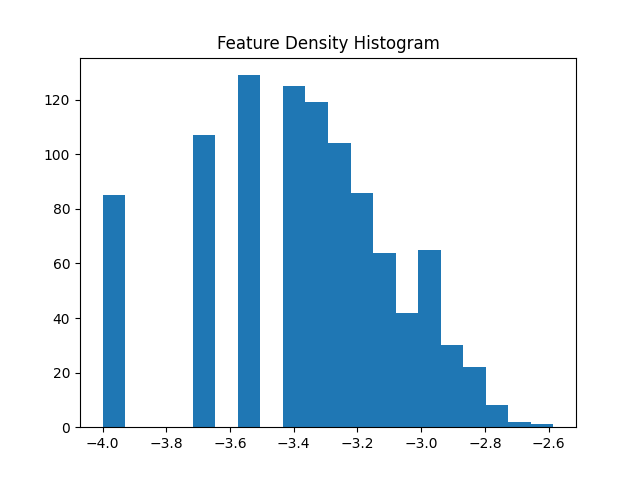

In [73]:
def get_n_feature_acts():
    n_feature_activations = torch.zeros(n_features, dtype=torch.float32) # number of tokens on which a feature is active 

    for iter in range(eval_contexts // gpt_batch_size):
        
        if device_type == 'cuda':
            # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
            x = X[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].pin_memory().to(device, non_blocking=True)
            y = Y[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].pin_memory().to(device, non_blocking=True)
        else:
            x = X[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].to(device)
            y = Y[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].to(device)
        
        mlp_activations = model.get_gelu_acts(x) # (gpt_b, t, n_ffwd)
        feature_activations = sae.get_feature_acts(mlp_activations) # (b, t, n_features)
        selected_feature_acts = torch.stack([feature_activations[i, selected_tokens_loc[iter], :] 
                                                for i in range(gpt_batch_size)])  # (b, tokens_per_eval_context, n_features)
        n_feature_activations += torch.count_nonzero(selected_feature_acts, dim=[0, 1]).to('cpu') # (n_features, )
    return n_feature_activations

n_feature_acts = get_n_feature_acts()
get_hist_image(np.log10(n_feature_acts[n_feature_acts != 0]/eval_tokens))


number of alive autoencoder neurons: 989


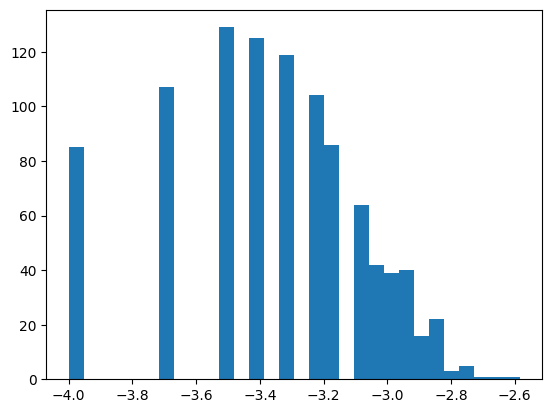

In [69]:
# n_feature_activations = torch.zeros(n_features, dtype=torch.float32) # number of tokens on which a feature is active 

# #### -------------- ####### 
# for iter in range(eval_contexts // gpt_batch_size):
    
#     if device_type == 'cuda':
#         # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
#         x = X[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].pin_memory().to(device, non_blocking=True)
#         y = Y[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].pin_memory().to(device, non_blocking=True)
#     else:
#         x = X[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].to(device)
#         y = Y[iter * gpt_batch_size: (iter + 1) * gpt_batch_size].to(device)
    
#     mlp_activations = model.get_gelu_acts(x) # (gpt_b, t, n_ffwd)
#     feature_activations = sae.get_feature_acts(mlp_activations) # (b, t, n_features)
#     selected_feature_acts = torch.stack([feature_activations[i, selected_tokens_loc[iter], :] 
#                                             for i in range(gpt_batch_size)])  # (b, tokens_per_eval_context, n_features)
#     n_feature_activations += torch.count_nonzero(selected_feature_acts, dim=[0, 1]).to('cpu') # (n_features, )
        
# import matplotlib.pyplot as plt
# print(f'number of alive autoencoder neurons: {n_feature_activations.count_nonzero()}')
# plt.hist(np.log10(n_feature_activations[n_feature_activations != 0]/eval_tokens), bins=30)

# plt.show()

In [54]:
# selected_feature_acts[:, :, 2] # feature activations for 0th feature

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
# 0: [(2.3, 3781), ] # (feature activation, token)

An observation:

- Feature density histogram only seems bimodal if you restrict to tokens_per_eval_context (10) tokens in each context before checking whether the feature is alive or dead on them. If you check for ALL tokens in each context, you will not see bimodality. To reproduce this, replace 'selected_feature_acts' by 'feature_acts' in the computation of 'n_feature_activations' above. A natural question is if this behavior also holds for GPT trained on OWT dataset.

In [ ]:
# TODO: when calling get_gelu_acts, should the model be in eval phase? I think so. This can affect dropout layers
# TODO: Why do dropout layers behave differently in eval vs train mode?
# TODO: perhaps torch.no_grad is not needed as both get_gelu_acts and get_feature_acts have torch.no_grad, but what about 
# nll computation?
# TODO: also compute nll loss from these mlp_acts; how do hooks work? do I need them?
# TODO: gpt_batch_size should be increased to the max value one can fit in the gpu ram!
# TODO: why were feature visualizations made after choosing ONLY 10 tokens from each of 10 million contexts? 
# how do the results change if you increase tokens per context or decrease number of contexts or both?
# say 50 tokens from each of 2 million contexts or 10 tokens each from 1 million contexts?

In [13]:
n_feature_activations

tensor([18., 15., 15.,  ...,  5., 27., 21.])

In [ ]:
# pick 10 million contexts and 10 tokens from each context
# compute feature activations on all 10 million contexts 
# look at feature activations on 10 tokens out of each context
# record feature densities --- fraction of tokens on which the feature has non-zero value
# keep a tensor of shape (n_features,) that keeps a record of the number of tokens on which the feature has taken 
# non_zero values
# plot feature histogram
# for each feature that is alive, record 10 out of 100 million tokens with largest activation values
# 
# perhaps this should be a dictionary of info; key: feature number; val: {'num_tokens':  , 'top_values': [(feature activation, token_number)]}
# record the token and its context of 4 letters on each side
# 

# when you have computed the 
# save the model weights and optimizer state dict

In [71]:



wandb.init(project='trying-tables')
for i in range(5):
    # Sample data for the histogram
    image = get_hist_image(data = np.random.randn(1000))
    wandb.log({"example_rgb_image": wandb.Image(image),
               "step": i*5})
wandb.finish()



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


step,▁▃▅▆█
step,20


In [ ]:
# This is good. But I want to do is something of the following form:

# for step in range of steps:
# ----- # perform training 
# ----- if step = 10000 or something:
# ----- ----- # TODO: how to calculate the feature density? how much data to use, etc?
              # I THINK I can take 10 million contexts, pick 10 tokens in each context and calculate feature activations on these 100 million tokens
              # TODO: should I choose different 10 million contexts every time during training?
              # perhaps I need to log the top 10 tokens (and a context of 4 tokens on each side) for each alive feature
                # perhaps there should be a widget that you can scroll through to see the top 10 tokens (and their contexts) for each 
# ----- ----- TECHNICALLY EASY: log the number of features in the high density cluster; TODO: It's hard to define a cutoff
# ----- ----- TECHNICALLY EASY: log the minimimum feature density of the high density cluster; TODO: It's hard to define a cutoff
# ----- ----- TECHNICALLY EASY: log the number of features with density above 1%; if it's too high, increase the L1 coefficient 
# ----- ----- TECHNICALLY EASY: plotting the histogram
# ----- ----- TECHNICALLY EASY: log the number of alive autoencoder neurons (i.e. those in the high density cluster + those in the ultralow density cluster)
# ----- ----- TECHNICALLY EASY: log the minimum feature density amongst alive autoencoder neurons
# ----- ----- 

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# import numpy as np

# # Sample data
# data = [np.random.normal(0, 1, 100) + i for i in range(10)]

# fig, ax = plt.subplots()
# bins = np.linspace(-5, 15, 30)

# def animate(i):
#     ax.clear()
#     ax.hist(data[i], bins=bins, color='blue', alpha=0.7)
#     ax.set_title(f"Histogram at Step {i}")

# ani = FuncAnimation(fig, animate, frames=len(data), interval=500)

# # Convert animation to HTML5 video and display
# html_video = HTML(ani.to_html5_video())

# # Close the figure to prevent displaying the static image
# plt.close(fig)

# # Display the HTML video
# html_video


In [35]:
import wandb
import numpy as np

# Initialize a wandb run
wandb.init(project='trying-tables')

for i in range(5):
    # Example array
    array = np.random.rand(10, 5)  # A 10x5 array

    # Convert array to wandb.Table
    table = wandb.Table(data=array, columns=[f"Col{i}" for i in range(array.shape[1])])

    # Log the table
    wandb.log({"my_array_table": table})

# Finish the run
wandb.finish()


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [ ]:
# For manual inspection, perhaps I could use a table 

In [ ]:
# Autoencoder neurons are going to be of three kinds.
# 1. In ultralow density cluster
# 2. In high density cluster
# 3. dead

# Ideally we want to minimize the number of neurons that are dead or are in the ultralow density cluster. That's perhaps where neuron resampling comes in?

In [ ]:
# Feature Density Histograms: Specific metrics from these histograms include:
# The number of alive features outside of the ultralow density cluster
# The minimum feature density at which we see a significant number of non-ultralow-density-cluster features.
# The number of features with density above 1%. A significant number of features above this level seems to correspond to an L1 coefficient that is too low.

#### Comments

1. Load the model checkpoint.
2. Evaluate the model on a bunch of (N) contexts from the dataset. This should likely be done after loading train.bin and val.bin
as is done in get_batch. 
3. After evaluation, obtain the activations of the linear layer in Transformer and save them somewhere.

I trained a 1 layer LM on Shakespeare dataset. It achieved training loss of 1.796 and validation loss of 1.920. block size was 64, batch size was 12, n_embd was 128, so n_ffwd was 512. 

With block size of 64 and batch size of 12, the number of tokens processed in each training step were 768. I trained for 2000 iterations so the total number of tokens was ~1.54M.

Now the Anthropic paper had trained on 100B tokens and collected a dataset of 10B activation vectors to train the autoencoder (by sampling activation vectors for 250 tokens each in 40 million contexts). Out of this, they used around 8.2B activation vectors for training the autoencoder. They trained for 1 million steps with batch size of 8192 (activation vectors where each vector is of length 512). 

For this work, I will ignore the validation dataset and just work with the training data (for now). I will, for now, choose around 1e5 contexts and sample 6 activation vectors to obtain a datset of 6e5 activation vectors. (I dont have a concrete reason for choosing this number of contexts contexts: just that my dataset is already pretty small, i.e. of 1.54M tokens only while Anthropic had 100B tokens so I might not be able to choose too many independent data points.)

So I think that all of the activations in the autoencoder dataset can be saved in one torch tensor or numpy array. 